In [3]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline 
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import math

In [4]:
##loading data for Z34C (300K)
#tica_data = np.load('proj14124_tica_lag_10_comp_4.npy', allow_pickle=True)    #tic_1,2,3,4
#tica_data = np.concatenate(tica_data)
tIC_1 = np.load('tIC_1.npy')
tIC_2 = np.load('tIC_2.npy')

ass = np.load('ass_clusters_100_lag_10_comp_4.npy', allow_pickle=True)
ass = np.concatenate(ass)
print (len(tIC_1), len(ass))
clusters = np.load('cluster_centers_100_lag_10_comp_4.npy', allow_pickle=True)
print ('clusters.shape=', clusters.shape)
unperturbed_pops = np.load('unperturbed_pops.npy')

1127900 1127900
clusters.shape= (100, 4)


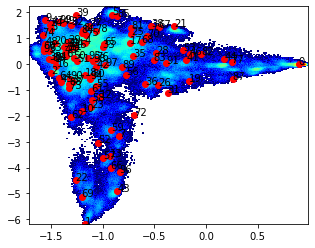

In [5]:
##plotting tic_1 vs tic_2
plt.figure(figsize=(5,4))
plt.hist2d(tIC_1, tIC_2, bins=300, norm=LogNorm(),cmap=cm.jet)

for i in range(len(clusters)):
    plt.scatter(clusters[:,0][i], clusters[:,1][i], color='r')
    plt.text(clusters[:,0][i], clusters[:,1][i], i, color='k')

### Visualizing each state

For the 2D kernel density plot to be a beautiful as possible, let's confirm that each cluster is roughly a Gaussian-shaped blob in (tIC$_1$,tIC$_2$) space

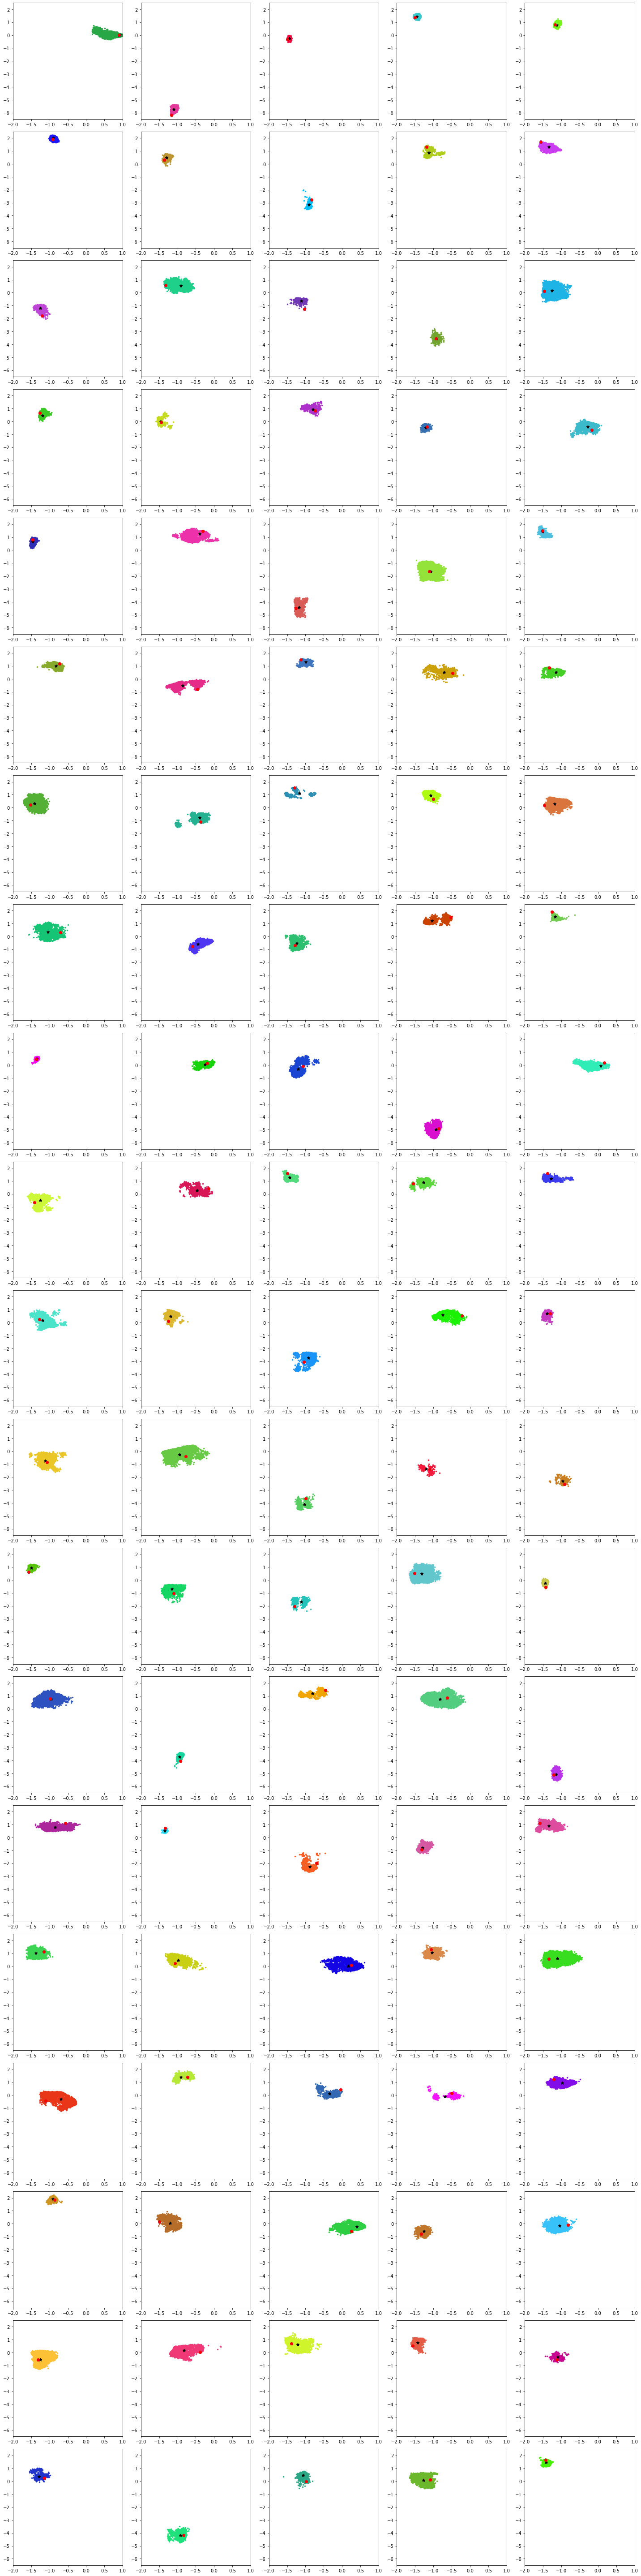

In [25]:
import colorsys

plt.figure(figsize=(20,80))
nclusters = 100

cluster_means     = np.zeros( (nclusters, 2) ) # store the x,y coords of each cluster mean
cluster_variances = np.zeros( (nclusters, 2) ) # store the sigma^2_x, and sigma^2_y of each cluster 

for i in range(nclusters):
    
    plt.subplot(20,5,i+1)
    
    # pick a random (bright) color   (see: https://stackoverflow.com/questions/43437309/get-a-bright-random-colour-python)
    h,s,l = np.random.random(), 0.5 + np.random.random()/2.0, 0.4 + np.random.random()/5.0
    rgb_color = tuple( colorsys.hls_to_rgb(h,l,s) )
    #print('rgb_color', rgb_color)
    
    Ind = (ass == i)
    #print(i, Ind)    
    plt.scatter(tIC_1[Ind], tIC_2[Ind], marker='.', linewidths=0.5, color=rgb_color)
    
    # compute the means and compare it the cluster centers
    cluster_means[i,:]     = np.mean(tIC_1[Ind]), np.mean(tIC_2[Ind])
    plt.scatter(cluster_means[i,0], cluster_means[i,1], marker='*', linewidths=1.5, color='k')
    plt.scatter(clusters[i,0], clusters[i,1], marker='*', linewidths=1.5, color='b')
    
    # compute the variances
    cluster_variances[i,:] = np.var(tIC_1[Ind]), np.var(tIC_2[Ind])
    
    plt.scatter(clusters[:,0][i], clusters[:,1][i], color='r')
    plt.xlim(-2, 1)
    plt.ylim(-6.5, 2.5)

plt.tight_layout()
plt.show()

### ... So, the actual mean of the 2D project is pretty close to the cluster center ($k$-means in 4D tICA space)

Let's use the cluster center as the mean of each Gaussian

In [36]:
# 2D kernel density contour plot for tIC_1 and 2
from numpy import meshgrid

# 1D kernel density function;   
def kernel_func_1D(x, mu, sigma):
    """x: xgrid or ygrid
       mu: tIC_1 or tIC_2
       sigma:   """
    k_1 = 1/(np.sqrt(2* math.pi *sigma **2)) * np.exp(-1.0 *(x - mu)**2/(2* sigma **2))
    return k_1

# 2D kernel density function;   
def kernel_func_2D(x, y, mu_x, mu_y, var_x, var_y):
    """Returns the value of the 2D kernel at (x, y)."""
    k_2 = (1.0/2.0*math.pi)*(1.0/np.sqrt(var_x*var_y))
    k_2 *= np.exp(-1.0*(x - mu_x)**2/(2.0*var_x))
    k_2 *= np.exp(-1.0*(y - mu_y)**2/(2.0*var_y))
    return k_2
                
# input data;
xgrid = np.linspace(np.amin(tIC_1)-0.1, np.amax(tIC_1)+0.1, 100)
ygrid = np.linspace(np.amin(tIC_2)-0.1, np.amax(tIC_2)+0.1, 100)
#print('xgrid', xgrid) 

density = np.zeros( (len(xgrid), len(ygrid)) )

for i in range(len(xgrid)):
    if i % 10 == 0:
        print('Filling xgrid', i, 'of', len(xgrid), '...')
    for j in range(len(ygrid)): 
        
        for k in range(len(unperturbed_pops)):
            pi = unperturbed_pops[k]
            mu_x, mu_y = clusters[k, 0], clusters[k, 1]
            var_x, var_y = cluster_variances[k, 0], cluster_variances[k, 1]
            density[i, j] += pi * kernel_func_2D(xgrid[i], ygrid[j], mu_x, mu_y, var_x, var_y)
print ('density.shape=', density.shape)

print('...Done.')

Filling xgrid 0 of 100 ...
Filling xgrid 10 of 100 ...
Filling xgrid 20 of 100 ...
Filling xgrid 30 of 100 ...
Filling xgrid 40 of 100 ...
Filling xgrid 50 of 100 ...
Filling xgrid 60 of 100 ...
Filling xgrid 70 of 100 ...
Filling xgrid 80 of 100 ...
Filling xgrid 90 of 100 ...
density.shape= (100, 100)
...Done.


(100, 100)


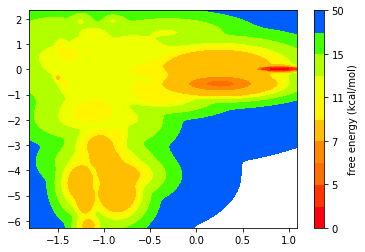

In [67]:
# print('unperturbed_pops', unperturbed_pops)

F_ = -1.0* 0.5961* np.log(density)
F_ -= F_.min()
print (F_.shape)


plt.contourf(xgrid, ygrid, F_.transpose(), levels=[0,2,5,6,7,10,11,12, 15,20,50],  cmap='gist_rainbow')   # jet
cbar = plt.colorbar()
cbar.set_label('free energy (kcal/mol)')
plt.show()

"""Supported colormaps:
supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r',
'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys',
'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1',
'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r',
'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu',
'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r',
'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r',
'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r',
'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r',
'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r',
'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow',
'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2',
'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r',
'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink',
'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r',
'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r',
'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted',
'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'
"""
print()

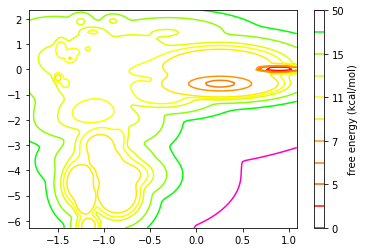

In [68]:
plt.contour(xgrid, ygrid, F_.transpose(), levels=[0,2,5,6,7,10,11,12, 15,20,50],  cmap='gist_rainbow')   # jet
cbar = plt.colorbar()
cbar.set_label('free energy (kcal/mol)')
plt.show()